In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib as mpl

grayImage = r'D:\py\python\Computer Vision\Image\albert-einstein_gray.jpg';
colourImage = r'D:\py\python\Computer Vision\Image\tulips.jpg';
I_gray = cv2.imread(grayImage, cv2.IMREAD_GRAYSCALE);
I_BGR = cv2.imread(colourImage);
numRows = I_gray.shape[0];
numCols = I_gray.shape[1];

In [2]:
def f_bilinearInterpolate(r, c, I):
    lc = int(c);
    rc = lc + 1;
    wr = c - lc;
    wl = rc - c;
    tr = int(r);
    br = tr + 1;
    wt = br - r;
    wb = r - tr;
    if tr >= 0 and br < I.shape[0] and lc >= 0 and rc < I.shape[1]:
        a = wl*I[tr, lc] + wr*I[tr, rc];
        b = wl*I[br, lc] + wr*I[br, rc];
        g = wt*a + wb*b;
        return np.uint8(g);
    else:
        return 0;

In [3]:
def displayImageInActualSize(I):
    dpi = mpl.rcParams['figure.dpi'];
    H, W = I.shape[0:2];
    figSize = W/float(dpi), H/float(dpi);
    fig = plt.figure(figsize = figSize);
    ax = fig.add_axes([0, 0, 1, 1]);
    ax.axis('off');
    ax.imshow(I, cmap='gray');
    plt.show;

In [4]:
angle = 45;
ca = np.cos(np.deg2rad(angle));
sa = np.sin(np.deg2rad(angle));
R = np.array([[ca, -sa], [sa, ca]]);
rMax = I_gray.shape[0];
cMax = I_gray.shape[1];
Cords = np.array([[0, 0], [0, cMax-1], [rMax-1, 0], [rMax-1, cMax-1]]);
A_dash = R.dot(Cords.T);
mins = A_dash.min(axis=1);
maxs = A_dash.max(axis=1);
minR = np.int64(np.floor(mins[0]));
minC = np.int64(np.floor(mins[1]));
maxR = np.int64(np.ceil(maxs[0]));
maxC = np.int64(np.ceil(maxs[1]));
H = maxR - minR + 1;
W = maxC - minC + 1;
I2 = np.zeros((H, W), dtype='uint8');

In [5]:
Tinv = np.linalg.inv(R);
for new_i in range(minR, maxR):
    for new_j in range(minC, maxC):
        P_dash = np.array([new_i, new_j]);
        P = Tinv.dot(P_dash);
        i = P[0];
        j = P[1];
        if i < 0 or i >= numRows or j < 0 or j >= numCols:
            pass
        else:
            g = f_bilinearInterpolate(i, j, I_gray);
            I2[new_i - minR, new_j - minC] = g;

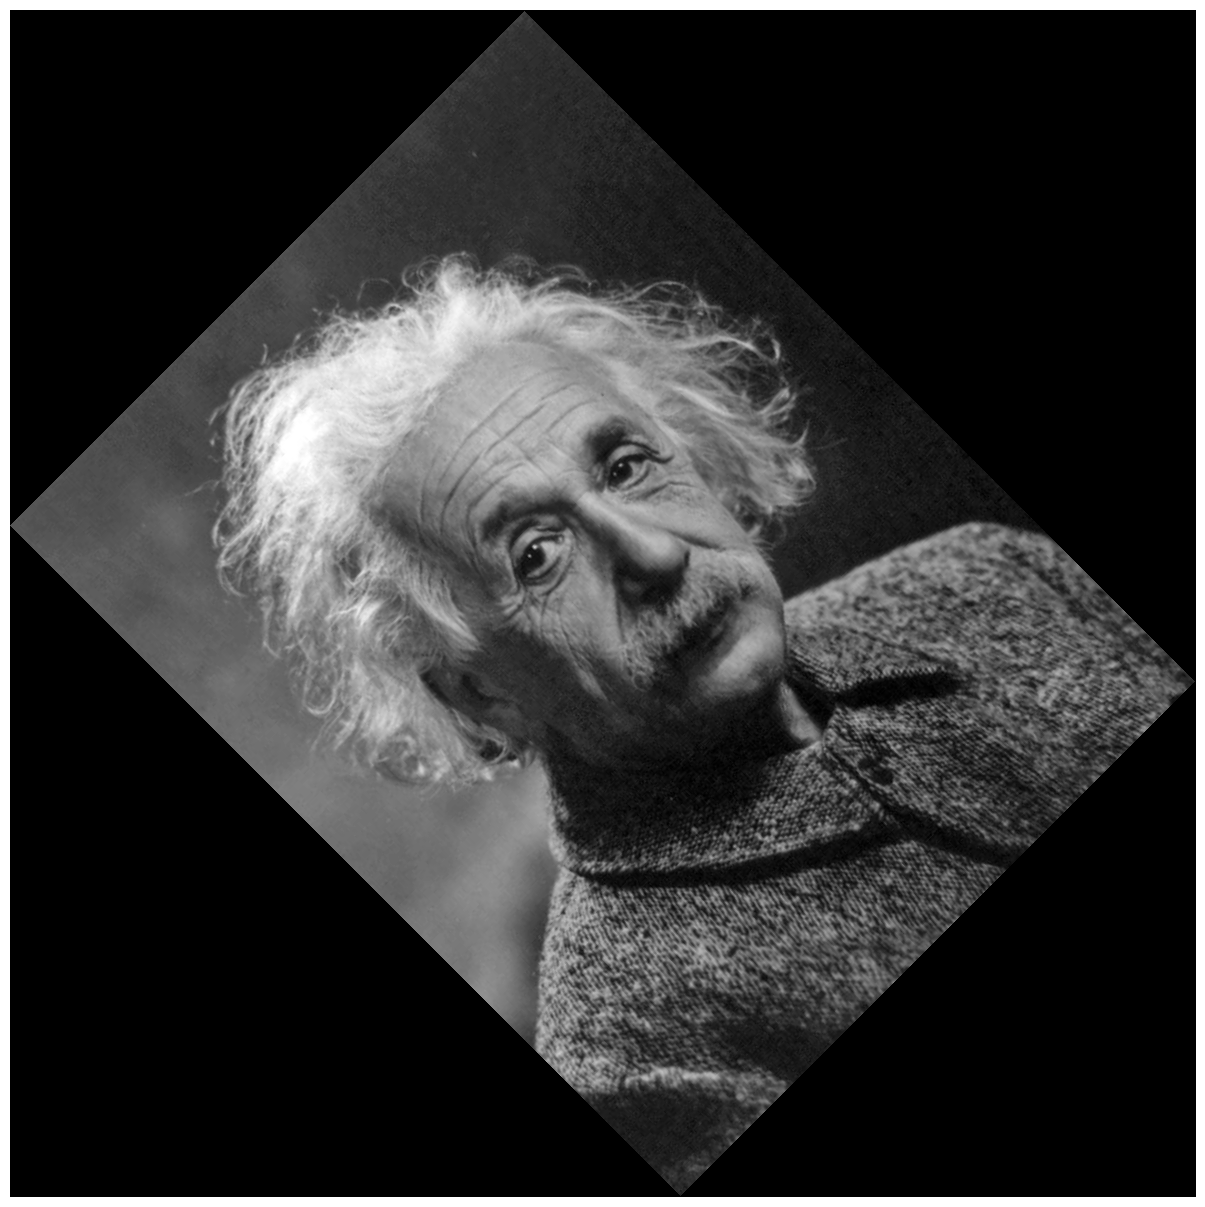

In [6]:
displayImageInActualSize(I2);

In [7]:
def f_getextents(T, rMax, cMax):
    Cords = np.array([[0, 0], [0, cMax-1], [rMax-1, 0], [rMax-1, cMax-1]]);
    A_dash = T.dot(Cords.T);
    mins = A_dash.min(axis=1);
    maxs = A_dash.max(axis=1);
    minR = np.int64(np.floor(mins[0]));
    minC = np.int64(np.floor(mins[1]));
    maxR = np.int64(np.ceil(maxs[0]));
    maxC = np.int64(np.ceil(maxs[1]));
    H = maxR - minR + 1;
    W = maxC - minC + 1;
    return minR, minC, maxR, maxC, H, W;

In [8]:
def f_transform(T, I_gray):
    rMax = I_gray.shape[0];
    cMax = I_gray.shape[1];
    minR, minC, maxR, maxC, H, W = f_getextents(T, rMax,cMax);
    I2 = np.zeros((H, W), dtype='uint8');
    Tinv = np.linalg.inv(T);
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j]);
            P = Tinv.dot(P_dash);
            i = P[0];
            j = P[1];
            if i < 0 or i >= numRows or j < 0 or j >= numCols:
                pass
            else:
                g = f_bilinearInterpolate(i, j, I_gray);
                I2[new_i - minR, new_j - minC] = g;
    return I2;

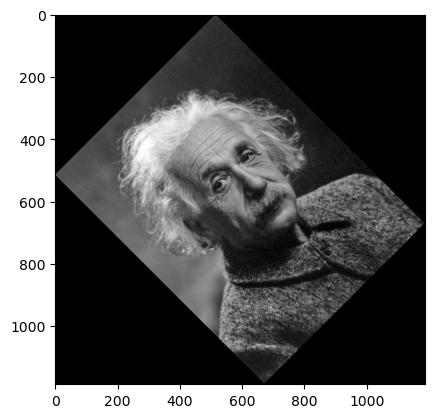

In [9]:
T = np.array([[ca, -sa], [sa, ca]]);
I2 = f_transform(T, I_gray);
plt.imshow(I2, cmap='gray');

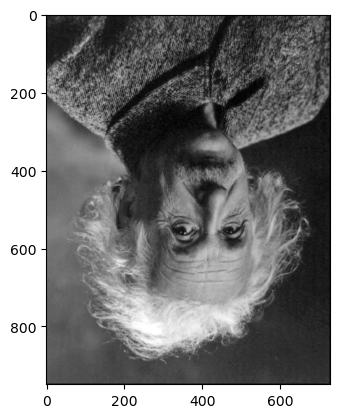

In [10]:
T = np.array([[-1, 0], [0, 1]]);
I2 = f_transform(T, I_gray);
plt.imshow(I2, cmap='gray');

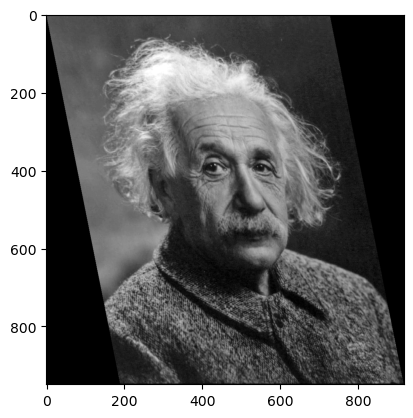

In [11]:
k = 0.2;
T = np.array([[1, 0], [k, 1]]);
I2 = f_transform(T, I_gray);
plt.imshow(I2, cmap='gray');

In [12]:
def f_getextentsAffine(T, rMax, cMax):
    Cords = np.array([[0, 0, 1], [0, cMax-1, 1], [rMax-1, 0, 1], [rMax-1, cMax-1, 1]]);
    A_dash = T.dot(Cords.T);
    mins = A_dash.min(axis=1);
    maxs = A_dash.max(axis=1);
    minR = np.int64(np.floor(mins[0]));
    minC = np.int64(np.floor(mins[1]));
    maxR = np.int64(np.ceil(maxs[0]));
    maxC = np.int64(np.ceil(maxs[1]));
    H = maxR - minR + 1;
    W = maxC - minC + 1;
    return minR, minC, maxR, maxC, H, W;
    

In [13]:
def f_transformAffine(T, I_gray):

    # 取得縮放前圖像的行數和列數
    rMax = I_gray.shape[0];
    cMax = I_gray.shape[1];

     # 取得縮放後圖像的邊界
    minR, minC, maxR, maxC, H, W = f_getextentsAffine(T, rMax,cMax);

    # 建立縮放後圖像
    I2 = np.zeros((H, W), dtype='uint8');

    # 計算 T 的逆矩陣 Tinv
    Tinv = np.linalg.inv(T);

    # 使用二重迴圈跑完縮放後圖像
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            # 定義一個新的座標 P_dash
            P_dash = np.array([new_i, new_j, 1]);
            # 計算出在縮放前圖像中對應的座標 P
            P = Tinv.dot(P_dash);
            # 取得 i, j 座標
            i = P[0];
            j = P[1];
            # 判斷是否超出圖像邊界
            if i < 0 or i >= numRows or j < 0 or j >= numCols:
                pass
            else:
                g = f_bilinearInterpolate(i, j, I_gray);
                I2[new_i - minR, new_j - minC] = g;
    return I2;

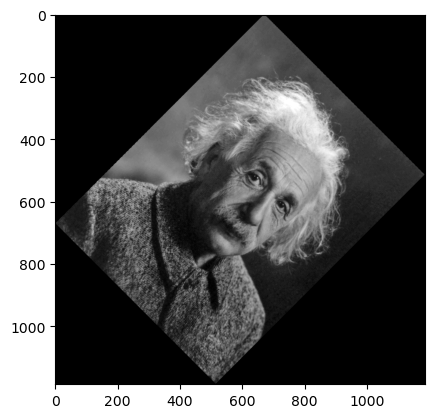

In [24]:
T = np.array([[2, 0, 10], [0, 0.5, 20],[0, 0, 1]]);
I2 = f_transformAffine(T, I_gray);
plt.imshow(I2, cmap='gray');

In [26]:
angle = 45;
ca = np.cos(np.deg2rad(angle));
sa = np.sin(np.deg2rad(angle));
R = np.array([[ca, -sa, 0], [sa, ca, 0],[0, 0, 1]]);
T = np.array([[1, 0, -300], [0, 1, -400], [0, 0, 1]]);
Sh = np.array([[1, 0.7, 0], [0.5, 1, 0], [0, 0, 1]]);
S = np.array([[1.3, 0, 0], [0, 0.7, 0], [0, 0, 1]]);
A = np.linalg.inv(T).dot(S).dot(R).dot(Sh).dot(T);

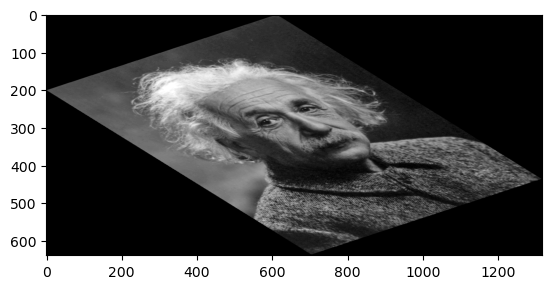

In [27]:
I2 = f_transformAffine(A, I_gray);
plt.imshow(I2, cmap='gray');

In [20]:
angle = -45;
ca = np.cos(np.deg2rad(angle));
sa = np.sin(np.deg2rad(angle));
R = np.array([[ca, -sa, 0], [sa, ca, 0],[0, 0, 1]]);
T = np.array([[1, 0, -2], [0, 1, 0], [0, 0, 1]]);
Rf = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]]);
A = np.linalg.inv(T).dot(np.linalg.inv(R)).dot(Rf).dot(R).dot(T);


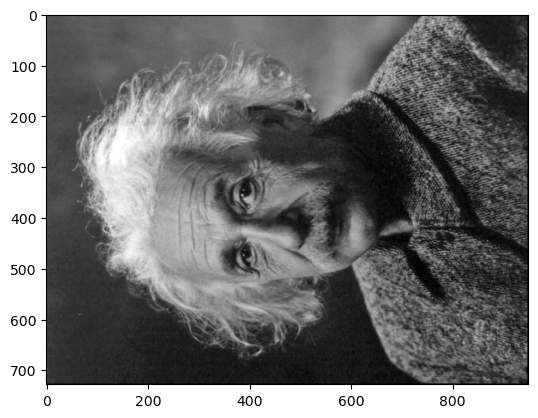

In [21]:
I2 = f_transformAffine(A, I_gray);
plt.imshow(I2, cmap='gray');

In [ ]:
angle = 30;
ca = np.cos(np.deg2rad(angle));
sa = np.sin(np.deg2rad(angle));
R = np.array([[ca, -sa], [sa, ca,]]);

In [ ]:
np.linalg.det(R)

1.0

In [ ]:
np.linalg.inv(R)

array([[ 0.8660254,  0.5      ],
       [-0.5      ,  0.8660254]])

In [ ]:
R.T

array([[ 0.8660254,  0.5      ],
       [-0.5      ,  0.8660254]])

In [ ]:
Rf = R[[1, 0], :]
Rf

array([[ 0.5      ,  0.8660254],
       [ 0.8660254, -0.5      ]])

In [ ]:
np.linalg.det(Rf)

-1.0

In [ ]:
Rf.T

array([[ 0.5      ,  0.8660254],
       [ 0.8660254, -0.5      ]])

In [ ]:
np.linalg.inv(Rf)

array([[ 0.5      ,  0.8660254],
       [ 0.8660254, -0.5      ]])

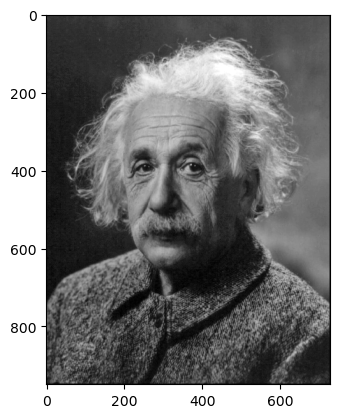

In [25]:
A = np.array([[Rf[0, 0], Rf[0, 1], 0], [Rf[1, 0], Rf[1, 1], 0], [0, 0, 1]])
I2 = f_transformAffine(A, I_gray);
plt.imshow(I2, cmap='gray');

In [ ]:
def f_getextentsProjective(T, rMax, cMax):
    Cords = np.array([[0, 0, 1], [0, cMax-1, 1], [rMax-1, 0, 1], [rMax-1, cMax-1, 1]]);
    A_dash = T.dot(Cords.T);
    A_dash = A_dash/A_dash[2, :];
    mins = A_dash.min(axis=1);
    maxs = A_dash.max(axis=1);
    minR = np.int64(np.floor(mins[0]));
    minC = np.int64(np.floor(mins[1]));
    maxR = np.int64(np.ceil(maxs[0]));
    maxC = np.int64(np.ceil(maxs[1]));
    H = maxR - minR + 1;
    W = maxC - minC + 1;
    return minR, minC, maxR, maxC, H, W;


In [ ]:
def f_transformProjective(T, I_gray):

    # 取得縮放前圖像的行數和列數
    rMax = I_gray.shape[0];
    cMax = I_gray.shape[1];

    # 取得縮放後圖像的邊界
    minR, minC, maxR, maxC, H, W = f_getextentsProjective(T, rMax,cMax);

    # 建立縮放後圖像
    I2 = np.zeros((H, W), dtype='uint8');

    # 計算 T 的逆矩陣 Tinv
    Tinv = np.linalg.inv(T);

    # 使用二重迴圈遍歷縮放後圖像
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):

            # 定義一個新的座標 P_dash
            P_dash = np.array([new_i, new_j, 1]);

            # 計算出在縮放前圖像中對應的座標 P
            P = Tinv.dot(P_dash);

            # 除以 P[2] 以取得最終座標
            P = P/P[2];

            # 取得 i, j 座標
            i = P[0];
            j = P[1];
            if i < 0 or i >= numRows or j < 0 or j >= numCols:
                pass
            else:
                g = f_bilinearInterpolate(i, j, I_gray);
                I2[new_i - minR, new_j - minC] = g;
    return I2;

In [ ]:
angle = 30;
ca = np.cos(np.deg2rad(angle));
sa = np.sin(np.deg2rad(angle));
R = np.array([[ca, -sa, 0], [sa, ca, 0],[0, 0, 1]]);
T = np.array([[1, 0, -300], [0, 1, -400], [0, 0, 1]]);
Sh = np.array([[1, 0.5, 0], [0, 1, 0], [0, 0, 1]]);
S = np.array([[1.3, 0, 0], [0, 0.7, 0], [0, 0, 1]]);
A = np.linalg.inv(T).dot(S).dot(R).dot(Sh).dot(T);
H = A;
H[2, :] = np.array([0.001, 0.0001, 1]);

array([[ 1.12583302e+00, -8.70834875e-02, -2.91651246e+00],
       [ 3.50000000e-01,  7.81217783e-01, -1.74871131e+01],
       [ 1.00000000e-03,  1.00000000e-04,  1.00000000e+00]])

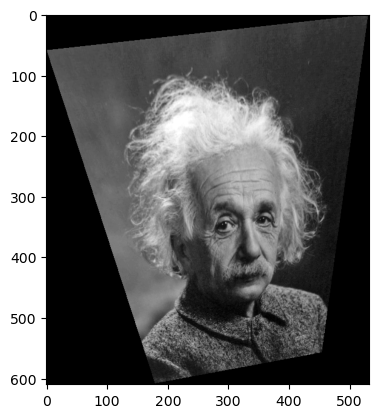

In [ ]:
I2 = f_transformProjective(H, I_gray);
plt.imshow(I2, cmap='gray');